In [1]:
import datetime
import math
import os
import pickle
import re
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.ops.tensor_utils import convolve
from scipy.interpolate import make_interp_spline
from scipy import interpolate
import seaborn as sns

### Lineage

In [2]:
coefficient_dataset = torch.load('./data/coefficient_dataset_Site_world_reparam.pkl')
# coefficient_dataset = torch.load('./data/coefficient_dataset_Site_reparam.pkl')

locations = coefficient_dataset['locations']
lineages = coefficient_dataset['lineages']
mutations = coefficient_dataset['mutations']
country_index = locations.index('Japan')

# beta_PL = coefficient_dataset['rate'][country_index,:].unsqueeze(0) # region
beta_PL = coefficient_dataset['rate'].sum(0).unsqueeze(0) # world
alpha_PL = coefficient_dataset['init']
beta_M = coefficient_dataset['coef']


In [3]:
lineage_fitness = beta_PL.sum(0) - beta_PL.sum(0)[lineages.index('B.1.1.529')]

lineage_fitness_value = lineage_fitness.sort(0, True)[0]
lineage_fitness_index = lineage_fitness.sort(0, True)[1].tolist()
lineage_fitness_name = []
for i in lineage_fitness_index:
    lineage_fitness_name.append(lineages[i])

relative_fitness = pow(1e3,lineage_fitness_value)
# lineage_fitness_value / lineage_fitness_value[lineage_fitness_name.index('B.1.1.529')]

In [4]:
dic = {
    'lineage' : lineage_fitness_name,
    'relative fitness' : relative_fitness
}
lineage_fitness = pd.DataFrame(dic)

In [6]:
dataset = torch.load('./data/Omicron_experimental_data_new.pkl')

# counts = dataset['counts'][:,country_index,:]
counts = dataset['counts'].sum(1) # world
time_step_days = dataset["time_step_days"]
start_date = dataset['start_date']

In [7]:
lineage_fitness['start date'] = ''
# lineage_fitness['date index'] = ''
for i in range(len(lineage_fitness)):
    lineage_index = lineages.index(lineage_fitness['lineage'][i])
    for j in range(counts.shape[0]):
        if counts[j, lineage_index] != 0 and counts[j+1, lineage_index] != 0 and counts[j+2, lineage_index] != 0 and counts[j+3, lineage_index] != 0:
            lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
            # lineage_fitness['date index'][i] = j
            break
            
for i in range(len(lineage_fitness)):
    if not lineage_fitness['start date'][i]:
        lineage_index = lineages.index(lineage_fitness['lineage'][i])
        for j in range(counts.shape[0]):
            if counts[j, lineage_index] != 0:
                lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
                break

lineage_fitness['count'] = ''
for i in range(len(lineage_fitness)):
    lineage_index = lineages.index(lineage_fitness['lineage'][i])
    lineage_fitness['count'][i] = counts[:, lineage_index].sum().item()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/2819814339.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/2819814339.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['start date'][i] = (start_date + datetime.timedelta(days=j*4)).strftime('%Y-%m-%d')
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/2819814339.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [8]:
lineage_fitness['color'] = ''
for i in range(len(lineage_fitness)):
    if lineage_fitness['lineage'][i].startswith('XB') or lineage_fitness['lineage'][i].startswith('E') or lineage_fitness['lineage'][i].startswith('F') or lineage_fitness['lineage'][i].startswith('G') or lineage_fitness['lineage'][i].startswith('H'):
        lineage_fitness['color'][i] = 'blue'
    else:
        lineage_fitness['color'][i] = 'red'

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/824024708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['color'][i] = 'red'
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/824024708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineage_fitness['color'][i] = 'blue'


In [9]:
size = []
color = []
for i in range(len(lineage_fitness)):
    # size.append(lineage_fitness['count'][i] * 0.1)
    size.append(lineage_fitness['count'][i] * 0.01) # world
    color.append(lineage_fitness['color'][i])

In [10]:
### extract label lineage
label_lineage = pd.DataFrame(columns = ['lineage', 'relative_fitness', 'start date', 'count'])
for i in range(len(lineage_fitness)):
    if i < 5:
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)
    elif lineage_fitness['count'][i] > 200000 and lineage_fitness['lineage'][i] != 'Unassigned': # world
    # elif lineage_fitness['count'][i] > 8000 and lineage_fitness['lineage'][i] != 'Unassigned': # region
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)
    elif lineage_fitness['lineage'][i] == 'XBB.1.5' or lineage_fitness['lineage'][i] == 'XBB.1.16' or lineage_fitness['lineage'][i] == 'EG.5.1' or lineage_fitness['lineage'][i] == 'BQ.1.1' or lineage_fitness['lineage'][i] == 'BF.5' or lineage_fitness['lineage'][i] == 'BF.7' or lineage_fitness['lineage'][i] == 'HK.3' or lineage_fitness['lineage'][i] == 'BA.1.1' or lineage_fitness['lineage'][i] == 'BA.2':
        s = pd.Series([lineage_fitness['lineage'][i], lineage_fitness['relative fitness'][i], lineage_fitness['start date'][i], lineage_fitness['count'][i]], index=label_lineage.columns)
        label_lineage = label_lineage.append(s, ignore_index=True)

label_lineage_marker = []
size1 = []
for i in range(len(label_lineage)):
    label_lineage_marker.append('$' + label_lineage['lineage'][i] + '$')
    size1.append(label_lineage['count'][i] * 0.001)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/3864898589.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/3864898589.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/3864898589.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_lineage = label_lineage.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_44855/3864898589.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

Text(0, 0.5, 'Relative Fitness')

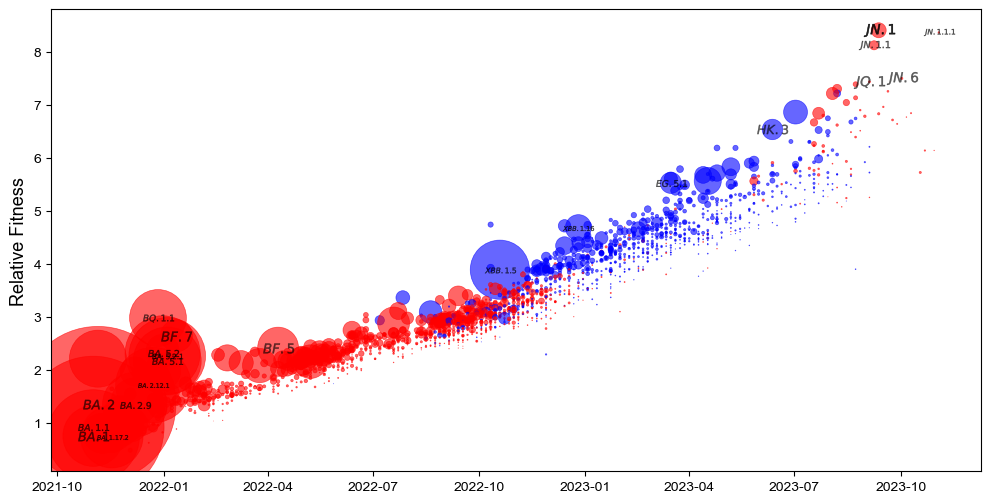

In [11]:
time = pd.to_datetime(lineage_fitness['start date'])
time1 = pd.to_datetime(label_lineage['start date'])

# plt.figure(figsize=(14,6))
# plt.figure(figsize=(6,3))
plt.figure(figsize=(12,6))
plt.rcParams['font.sans-serif'] = ['Arial']
plt.scatter(time, lineage_fitness['relative fitness'], s = size, c = color, alpha=0.6, lw=0.5)
for i in range(len(label_lineage_marker)):
    plt.scatter(time1[i], label_lineage['relative_fitness'][i], s = 500, c = 'black', marker = label_lineage_marker[i], alpha = 0.6, lw = 0.3)
plt.scatter(time1[0], label_lineage['relative_fitness'][0], s = 500, c = 'black', marker = label_lineage_marker[0], alpha = 0.6, lw = 0.3)

# plt.ylabel(('exp('+chr(916)+'$R/R_{A}$)'), fontsize=15)
plt.ylabel(('Relative Fitness'), fontsize=13)
# plt.xlabel(('Time'), fontsize=13)
# plt.text(0.1, 0.9, locations[country_index],
#             fontsize = 14,
#             horizontalalignment='center',
#             verticalalignment='center', 
#             transform=plt.gca().transAxes,
#             bbox=dict(boxstyle='round,pad=0.6',facecolor='white',alpha=0.6)
# )

### Mutation

In [2]:
coefficient_dataset = torch.load('./data/coefficient_dataset_Site_reparam.pkl')

beta_PL = coefficient_dataset['rate']
alpha_PL = coefficient_dataset['init']
beta_M = coefficient_dataset['coef']
locations = coefficient_dataset['locations']
lineages = coefficient_dataset['lineages']
mutations = coefficient_dataset['mutations']

In [3]:
mutation_fitness = beta_M

mutation_fitness_value = mutation_fitness.sort(0, True)[0]
mutation_fitness_index = mutation_fitness.sort(0, True)[1].tolist()
mutation_fitness_name = []
for i in mutation_fitness_index:
    mutation_fitness_name.append(mutations[i])

dic = {
    'mutation' : mutation_fitness_name,
    'fitness' : np.exp(mutation_fitness_value)
    }
mutation_fitness = pd.DataFrame(dic)

In [4]:
mutation_fitness['site'] = ''
for i in range(len(mutation_fitness)):
    try:
        mutation_fitness['site'][i] = int(mutation_fitness['mutation'][i][1:4])
    except:
        pass

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_43680/3391836037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutation_fitness['site'][i] = int(mutation_fitness['mutation'][i][1:4])


In [110]:
dataset = torch.load('./data/Omicron_experimental_data_new.pkl')

features_frequency = dataset['mutation_features'].mean(0)

mutation_fitness['frequency'] = ''
for i in range(len(mutation_fitness)):
    mutation_fitness['frequency'][i] = features_frequency[mutation_fitness_index[i]].item()

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_50277/2673449835.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutation_fitness['frequency'][i] = features_frequency[mutation_fitness_index[i]].item()


In [111]:
### extract label mutation
label_mutation = pd.DataFrame(columns = ['mutation', 'fitness', 'site', 'frequency'])
for i in range(len(mutation_fitness)):
    if i < 10:
        s = pd.Series([mutation_fitness['mutation'][i], mutation_fitness['fitness'][i], mutation_fitness['site'][i], mutation_fitness['frequency'][i]], index=label_mutation.columns)
        label_mutation = label_mutation.append(s, ignore_index=True)
    else:
        if mutation_fitness['frequency'][i] > 0.5:
            s = pd.Series([mutation_fitness['mutation'][i], mutation_fitness['fitness'][i], mutation_fitness['site'][i], mutation_fitness['frequency'][i]], index=label_mutation.columns)
            label_mutation = label_mutation.append(s, ignore_index=True)

label_mutation_marker = []
size1 = []
for i in range(len(label_mutation)):
    label_mutation_marker.append('$' + label_mutation['mutation'][i] + '$')
    size1.append(label_mutation['frequency'][i] * 1000)

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_50277/260490928.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_mutation = label_mutation.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_50277/260490928.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_mutation = label_mutation.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_50277/260490928.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  label_mutation = label_mutation.append(s, ignore_index=True)
/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_50277/260490928.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

Text(0, 0.5, '$e^{R}$')

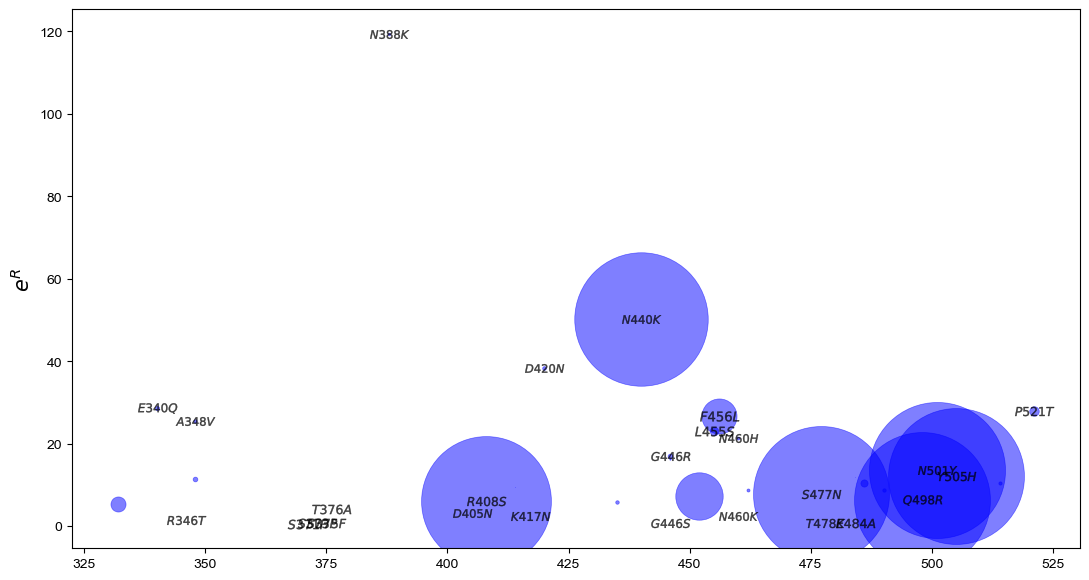

In [87]:
size = []
for i in range(len(mutation_fitness)):
    size.append(mutation_fitness['frequency'][i] * 10000)

plt.figure(figsize=(13,7))
for i in range(len(label_mutation_marker)):
    if mutation_fitness['mutation'][i] != '[]':
        plt.scatter(mutation_fitness['site'][i], mutation_fitness['fitness'][i], s = size[i], c = 'blue', alpha=0.5, lw=0.5)
for i in range(len(label_mutation_marker)):
    plt.scatter(label_mutation['site'][i], label_mutation['fitness'][i], s = 800, c = 'black', marker = label_mutation_marker[i], alpha = 0.7, lw = 0.3)


plt.ylabel('$e^{R}$', fontsize=15)

### fitness heatmap

In [5]:
mutation_fitness['aa_substitution'] = ''
for i in range(len(mutation_fitness)):
    try:
        mutation_fitness['aa_substitution'][i] = mutation_fitness['mutation'][i][-1]
    except:
        pass

/var/folders/b4/79t4ch4d6r75j7xb9y8qj3vc0000gn/T/ipykernel_43680/928912230.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutation_fitness['aa_substitution'][i] = mutation_fitness['mutation'][i][-1]


In [6]:
dic = {
    'site': mutation_fitness['site'],
    'aa' : mutation_fitness['aa_substitution'],
    'fitness' : mutation_fitness['fitness']
}
df_heatmap = pd.DataFrame(dic)

In [7]:
columns = defaultdict(list)
stats = defaultdict(Counter)

for i in range(len(df_heatmap)):
    if df_heatmap['aa'][i] == ']':
        pass
    else:
        site = df_heatmap['site'][i]
        aa = df_heatmap['aa'][i]
        fitness = df_heatmap['fitness'][i]

        columns['aa'].append(aa)
        columns['site'].append(site)
        columns['fitness'].append(fitness)

        stats['aa'][aa] +=1
        stats['site'][site] +=1
        stats['aa_site'][site, aa] = fitness
        # stats['aa_site'][site, aa] = math.log(fitness,2)
        # stats['aa_site'][site, aa] = math.pow(1.01,fitness)

columns = dict(columns)
stats = dict(stats)

aas = sorted(stats['aa'])
sites = sorted(stats['site'])

# aa_site_fitness = torch.zeros(len(sites), len(aas), dtype=torch.float)
# for s, site in enumerate(sites):
#     for f, aa in enumerate(aas):
#         count = stats["aa_site"].get((site, aa))
#         if count is None:
#             count = 0
#         aa_site_fitness[s, f] = float(count)

In [8]:
aa_site_fitness = torch.zeros(200, len(aas), dtype=torch.float)
for site in sites:
    for f, aa in enumerate(aas):
        count = stats["aa_site"].get((site, aa))
        if count is None:
            # count = math.log(pow(1.1,0),1000)
            count = np.nan
        aa_site_fitness[site-331, f] = float(count)

Text(172.72222222222223, 0.5, 'AA Substitution')

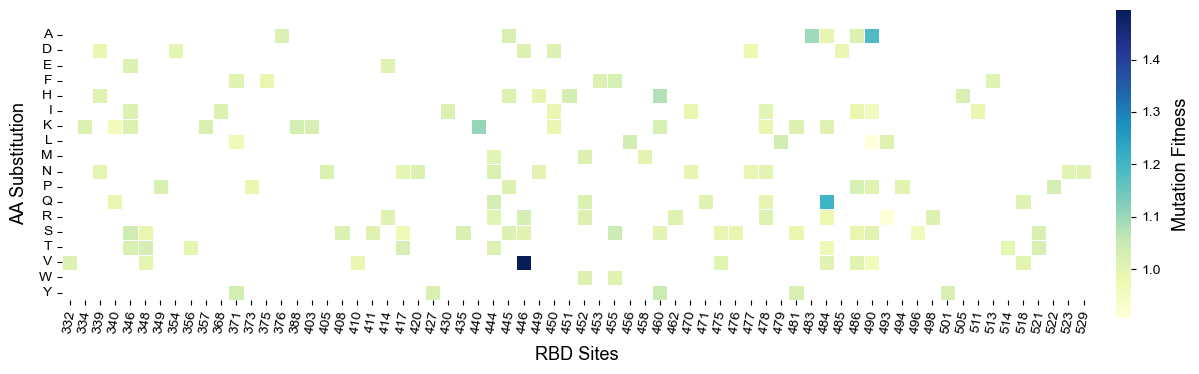

In [9]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(16,4))
plt.rcParams['font.sans-serif'] = ['Arial']
data = pd.DataFrame(aa_site_fitness.T)

sites_plot = []
for i in range(len(sites)):
    sites_plot.append(sites[i]-331)

data = data[sites_plot]

data = data.T
data.columns = aas
data.index = sites

data = data.T

ax = sns.heatmap(data, cmap = 'YlGnBu', square=True, linewidths=0.5, linecolor='white', cbar_kws={'pad':0.02})

colorbar = ax.collections[0].colorbar
colorbar.set_label('Mutation Fitness', fontsize=13, labelpad = 8)

plt.xticks(rotation=80)
plt.yticks(rotation=0)

plt.xlabel('RBD Sites', fontsize=13, labelpad = 8)
plt.ylabel('AA Substitution', fontsize=13, labelpad = 8)